# PROJECT:

# Airbnb Host Listings of New York: Analysis and Recommendations

Airbnb is that online market place that offers lodging, homestays, etc. The company doesn't itself own the real estate listings it mentions. All these estates are owned by the citizens of that particular country. Airbnb acts as a broker and receives commissions from ever booking.

New York is one of the populous cities of the US. The city gains a lot of tractions from tourists all over the world as they want to witness the American Dream in action. 

In this project we will work through to see the Airbnb host listings available all over New York and where can they expand. We shall also implement a filtering system and add another layer of filter to it by using FourSquare API.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # already installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Importing Folium to map the data
import folium 

print('Libraries imported.')

Libraries imported.


## DATASET

=================================================================================================================

**newyork_data.json** contains details (longitude and latitudes) of the neighbourhoods and boroughs in New York. We have data in a JSON file so we will take the necessary data out of it and shift it into DataFrame: **df_newyork**.

**NY_airbnb.csv** file contains the host listings all over New York. We shall import that into DataFrame:**df_airbnb**.

### New York Data

In [2]:
# Reading New York data into Dataframe
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
print('JSON data loaded successfully')

JSON data loaded successfully


In [3]:
# visualise the json data
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

The **features** key holds all the information we need. We shall store the dictionaries stored in this key onto another dictionary, here, **nydata**.
We shall, interview the first location entry to find out the keys with which we can access the data we require for further analysis.

In [4]:
# transfer the value of 'features' key into another dictionary
nydata = newyork_data['features']
# Observe the first entry
nydata[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

As we can see from above, **name**, **borough** under **properties** and **coordinates** under **geometry** are the values we require to create a DataFrame consisting of all neighborhoods in New York. Let's see the first 5 entries of our DataFrame **df_newyork**.

In [5]:
# create a DataFrame containing the lists of data we need
col_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
df_newyork = pd.DataFrame(columns = col_names)

# to transfer Borough and Neighbourhood names and Latitude and Longitude coordinates into the DataFrame
for data in nydata:
    borough = data['properties']['borough']
    name = data['properties']['name']
    latlong = data['geometry']['coordinates']
    long = latlong[0]
    lat = latlong[1]
    #print(borough)
    df_newyork = df_newyork.append({'Borough': borough,
                 'Neighborhood': name,
                 'Latitude': lat,
                 'Longitude': long}, ignore_index = True)

# visualise the first 5 entries  
df_newyork.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let's now see the total number of boroughs and neighborhoods in New York. We shall also see how many neighborhoods exist in each borough.

In [6]:
# find out the total number of neighbourhoods and boroughs in New York
print('New York has {} boroughs and {} neighbourhoods.'.format(
    len(df_newyork['Borough'].unique()), df_newyork.shape[0]))

New York has 5 boroughs and 306 neighbourhoods.


In [7]:
# count number of neighbourhoods in each borough
df_newyork.groupby('Borough').count()

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


#### Visualise all the neighbourhoods of New York on a map

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_newyork['Latitude'], df_newyork['Longitude'], df_newyork['Borough'], df_newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Airbnb host listings dataset

In [10]:
# Reading Airbnb data into DataFrame
df_airbnb = pd.read_csv('NY_airbnb.csv')
print('Airbnb data loaded successfully')
df_airbnb.head()

Airbnb data loaded successfully


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2060,Modern NYC,2259,Jenny,Manhattan,Washington Heights,40.85722,-73.93790,Private room,100,1,1,2008-09-22,0.01,1,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,7,48,2019-11-04,0.38,2,339
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,313,2020-02-23,4.71,1,151
3,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,78,2019-10-13,0.59,1,0
4,5114,Super Room in Great area.,7345,Yasmine,Manhattan,Lower East Side,40.71910,-73.99040,Private room,94,1,75,2012-06-09,0.56,3,109


We shall change the column names into better formatted titles.

In [11]:
# Change column names
df_airbnb.columns = ('ID', 'Name', 'Host ID', 'Host Name', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude', 'Room Type', 'Price', 'Minimum Nights', 'No. of Reviews', 'Last Review', 'Reviews per Month', 'Calculated host listings count', 'Availability')
df_airbnb.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,2060,Modern NYC,2259,Jenny,Manhattan,Washington Heights,40.85722,-73.93790,Private room,100,1,1,2008-09-22,0.01,1,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,7,48,2019-11-04,0.38,2,339
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,313,2020-02-23,4.71,1,151
3,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,78,2019-10-13,0.59,1,0
4,5114,Super Room in Great area.,7345,Yasmine,Manhattan,Lower East Side,40.71910,-73.99040,Private room,94,1,75,2012-06-09,0.56,3,109


Let's count the total number of listings that are present in all of New York as of April 2020.

In [12]:
# Gives the total number of listings in all of New York
print('The dataframe has {} Airbnb listings in all of New York'.format(df_airbnb.shape[0]))
print('This is spread all over {} boroughs of New York.'.format(
    len(df_airbnb['Borough'].unique())))

The dataframe has 50796 Airbnb listings in all of New York
This is spread all over 5 boroughs of New York.


Let's count the number of host listings in each borough of New York.

In [13]:
# count of listings in every Borough
df_airbnb.groupby('Borough').count()

,ID,Name,Host ID,Host Name,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
Borough,,,,,,,,,,,,,,,
Bronx,1249,1247,1249,1249,1249,1249,1249,1249,1249,1249,1249,1022,1022,1249,1249
Brooklyn,20455,20449,20455,20451,20455,20455,20455,20455,20455,20455,20455,16781,16781,20455,20455
Manhattan,22448,22439,22448,22447,22448,22448,22448,22448,22448,22448,22448,17106,17106,22448,22448
Queens,6266,6266,6266,6266,6266,6266,6266,6266,6266,6266,6266,5116,5116,6266,6266
Staten Island,378,378,378,378,378,378,378,378,378,378,378,318,318,378,378



### OBJECTIVE 1: Let's find out which Neighbourhoods in the Boroughs have no Airbnb hosts.


#### Bronx Borough

Filter out the host listings that are only present in Bronx.

In [14]:
# Host listings in Bronx Borough
df_airbronx = df_airbnb[df_airbnb['Borough']=='Bronx'].reset_index(drop=True)
df_airbronx.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,44096,Room with a View,190409,Waundell,Bronx,Highbridge,40.83232,-73.93184,Private room,38,1,277,2020-02-25,2.39,3,361
1,54626,Cozy bedroom by Yankee Stadium,190409,Waundell,Bronx,Highbridge,40.83075,-73.93058,Private room,42,1,181,2020-03-06,1.74,3,336
2,63588,LL3,295128,Carol Gloria,Bronx,Clason Point,40.81309,-73.85514,Private room,90,2,0,NaN,NaN,7,332
3,63610,DOMINIQUE'S NY mini efficiency pad** a rare fi...,310670,Vie,Bronx,Eastchester,40.88100,-73.83511,Entire home/apt,110,1,43,2020-01-02,0.51,12,365
4,71812,Condo Apartment with Laundry and Assigned Parking,369015,Thai,Bronx,Kingsbridge,40.87207,-73.90193,Entire home/apt,110,5,7,2020-01-08,0.35,2,5


Filter out the neighborhoods which are only present in Bronx.

In [15]:
# Neighbourhoods in Bronx
df_bronx = df_newyork[df_newyork['Borough']=='Bronx'].reset_index(drop=True)
df_bronx.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let's make a list of all the neighborhoods in Bronx that have Airbnb host listings.

In [16]:
# Make a list of neighbourhoods that have host listings
listBronx = df_airbronx['Neighbourhood'].unique()
listBronx

array(['Highbridge', 'Clason Point', 'Eastchester', 'Kingsbridge',
       'Woodlawn', 'University Heights', 'Allerton', 'Wakefield',
       'Spuyten Duyvil', 'Morris Heights', 'Mott Haven', 'Longwood',
       'Concourse', 'Mount Eden', 'City Island', 'Port Morris',
       'Williamsbridge', 'Soundview', 'Co-op City', 'Parkchester',
       'North Riverdale', 'Bronxdale', 'Riverdale', 'Norwood',
       'Claremont Village', 'Fordham', 'Concourse Village', 'Fieldston',
       'Mount Hope', 'Morris Park', 'Tremont', 'Hunts Point',
       'Pelham Bay', 'Throgs Neck', 'West Farms', 'Morrisania',
       'Pelham Gardens', 'Belmont', 'Baychester', 'Melrose', 'Van Nest',
       'Schuylerville', 'Olinville', 'Edenwald', 'East Morrisania',
       'Unionport', 'Westchester Square', 'Castle Hill', 'Country Club'],
      dtype=object)

Let's find out the neighborhoods that do not have Airbnb host listings. We will store that in a list name **listNoBronx**.

In [17]:
# Find out the neighbourhoods in Bronx that have no host listings
listNoBronx = list(set(df_bronx['Neighborhood']) - set(df_airbronx['Neighbourhood']))
print('Number of neighbourhoods that don\'t have host listings in Bronx are {}. '.format(len(listNoBronx)))
listNoBronx

Number of neighbourhoods that don't have host listings in Bronx are 6. 


['Bedford Park',
 'Kingsbridge Heights',
 'Pelham Parkway',
 'East Tremont',
 'High  Bridge',
 'Edgewater Park']

We create a new DataFrame **df1** that has the necessary details of those neighbourhoods that do not have any Airbnb host listings.

In [18]:
# Shift the neighbourhoods that don't have listings into a DataFrame
df1 = df_bronx[df_bronx['Neighborhood'].isin(listNoBronx)]
df1

,Borough,Neighborhood,Latitude,Longitude
10,Bronx,Pelham Parkway,40.857413,-73.854756
12,Bronx,Bedford Park,40.870185,-73.885512
16,Bronx,East Tremont,40.842696,-73.887356
18,Bronx,High Bridge,40.836623,-73.926102
38,Bronx,Edgewater Park,40.821986,-73.813885
51,Bronx,Kingsbridge Heights,40.870392,-73.901523


We create another DataFrame **yesdf1** that has the necessary details of those neighbourhoods that have any Airbnb host listings.

In [19]:
# Neighbourhoods in Bronx that do have listings
yesdf1 = df_bronx[~df_bronx['Neighborhood'].isin(listNoBronx)]
yesdf1.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Brooklyn Borough

Filter out those listings that are only present in Brooklyn.

In [20]:
# Host listings in Brooklyn Borough
df_airbrook = df_airbnb[df_airbnb['Borough']=='Brooklyn'].reset_index(drop=True)
df_airbrook.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,313,2020-02-23,4.71,1,151
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,29,50,2019-12-02,0.38,1,365
2,5803,"Lovely Room 1, Garden, Best Area, Legal rental",9744,Laurie,Brooklyn,South Slope,40.66829,-73.98779,Private room,89,4,179,2020-03-07,1.35,3,341
3,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,140,2,180,2020-03-09,1.37,1,41
4,7097,Perfect for Your Parents + Garden,17571,Jane,Brooklyn,Fort Greene,40.69121,-73.97277,Entire home/apt,199,1,223,2020-02-23,1.80,1,298


Filter out the neighborhoods that are present in Brooklyn.

In [21]:
# Neighbourhoods in Brooklyn
df_brook = df_newyork[df_newyork['Borough']=='Brooklyn'].reset_index(drop=True)
df_brook.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Make a list of neighborhoods that have host listings in Brooklyn.

In [22]:
# Make a list of neighbourhoods that have host listings
listBrook = df_airbrook['Neighbourhood'].unique()
listBrook

array(['Clinton Hill', 'Bedford-Stuyvesant', 'South Slope',
       'Williamsburg', 'Fort Greene', 'Crown Heights', 'Park Slope',
       'Bushwick', 'Flatbush', 'Prospect-Lefferts Gardens', 'Greenpoint',
       'Red Hook', 'Prospect Heights', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Boerum Hill', 'Windsor Terrace', 'Kensington', 'East Flatbush',
       'Gravesend', 'East New York', 'Sheepshead Bay', 'Fort Hamilton',
       'Bensonhurst', 'Sunset Park', 'DUMBO', 'Brighton Beach',
       'Cypress Hills', 'Bay Ridge', 'Columbia St', 'Borough Park',
       'Downtown Brooklyn', 'Vinegar Hill', 'Canarsie', 'Dyker Heights',
       'Sea Gate', 'Brownsville', 'Midwood', 'Navy Yard',
       'Manhattan Beach', 'Bergen Beach', 'Coney Island', 'Bath Beach',
       'Mill Basin', 'Gerritsen Beach'], dtype=object)

Make a list **listNoBrook** that contain a list of neighborhoods in Brooklyn that do not have host listings.

In [23]:
# Find out the neighbourhoods in Brooklyn that have no host listings
listNoBrook = list(set(df_brook['Neighborhood']) - set(df_airbrook['Neighbourhood']))
print('Number of neighbourhoods that don\'t have host listings in Brooklyn are {}. '.format(len(listNoBrook)))
listNoBrook

Number of neighbourhoods that don't have host listings in Brooklyn are 29. 


['Mill Island',
 'North Side',
 'Remsen Village',
 'Paerdegat Basin',
 'New Lots',
 'Homecrest',
 'Starrett City',
 'Bedford Stuyvesant',
 'Ditmas Park',
 'Marine Park',
 'East Williamsburg',
 'Ocean Hill',
 'Highland Park',
 'Manhattan Terrace',
 'Downtown',
 'Weeksville',
 'Wingate',
 'Madison',
 'Ocean Parkway',
 'Rugby',
 'Erasmus',
 'Georgetown',
 'Fulton Ferry',
 'Dumbo',
 'Prospect Lefferts Gardens',
 'City Line',
 'Prospect Park South',
 'South Side',
 'Broadway Junction']

We create a DataFrame **df2** that contains all the neighborhoods that do not have host listings.

In [24]:
# Shift the neighbourhoods that don't have listings into a DataFrame
df2 = df_brook[df_brook['Neighborhood'].isin(listNoBrook)]
df2.head()

,Borough,Neighborhood,Latitude,Longitude
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438
17,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785
27,Brooklyn,Starrett City,40.647589,-73.879370
30,Brooklyn,Mill Island,40.606336,-73.908186
37,Brooklyn,Marine Park,40.609748,-73.931344


We create another DataFrame **yesdf2** that contains all neighborhoods that have host listings.

In [25]:
# Neighbourhoods in Brooklyn that have listings
yesdf2 = df_brook[~df_brook['Neighborhood'].isin(listNoBrook)]
yesdf2.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


We create a main DataFrame **df**. that contains the all neighbourhoods of all boroughs that do not have host listings. 

In [26]:
# Append to existing DataFrame that don't have listings
df = df1.append(df2).reset_index(drop=True)
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Pelham Parkway,40.857413,-73.854756
1,Bronx,Bedford Park,40.870185,-73.885512
2,Bronx,East Tremont,40.842696,-73.887356
3,Bronx,High Bridge,40.836623,-73.926102
4,Bronx,Edgewater Park,40.821986,-73.813885


We create another main DataFrame **yesdf** that contains all neighborhoods of all boroughs that have host listings.

In [27]:
# Appending to existing DataFrame that have listings
yesdf = yesdf1.append(yesdf2).reset_index(drop=True)
yesdf.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Manhattan Borough

Filter out listings that are only present in Manhattan.

In [28]:
# Host listings in Manhattan Borough
df_airman = df_airbnb[df_airbnb['Borough']=='Manhattan'].reset_index(drop=True)
df_airman.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,2060,Modern NYC,2259,Jenny,Manhattan,Washington Heights,40.85722,-73.93790,Private room,100,1,1,2008-09-22,0.01,1,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,7,48,2019-11-04,0.38,2,339
2,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,78,2019-10-13,0.59,1,0
3,5114,Super Room in Great area.,7345,Yasmine,Manhattan,Lower East Side,40.71910,-73.99040,Private room,94,1,75,2012-06-09,0.56,3,109
4,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,470,2020-02-28,3.56,1,207


Filter out the neighborhoods that are present in Manhattan borough.

In [29]:
# Neighbourhoods in Manhattan
df_man = df_newyork[df_newyork['Borough']=='Manhattan'].reset_index(drop=True)
df_man.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Make a list of neighborhoods that have host listings.

In [30]:
# Make a list of neighbourhoods that have host listings
listMan = df_airman['Neighbourhood'].unique()
listMan

array(['Washington Heights', 'Midtown', 'Murray Hill', 'Lower East Side',
       "Hell's Kitchen", 'Upper West Side', 'Chinatown', 'West Village',
       'East Harlem', 'Inwood', 'East Village', 'Harlem', 'Kips Bay',
       'Nolita', 'Chelsea', 'Upper East Side', 'Tribeca',
       'Morningside Heights', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'Gramercy', 'Two Bridges',
       'NoHo', 'SoHo', 'Theater District', 'Financial District',
       'Civic Center', 'Battery Park City', 'Stuyvesant Town',
       'Marble Hill'], dtype=object)

Make a list of neighborhoods that do not have host listings.

In [31]:
# Find out the neighbourhoods in Manhattan that have no host listings
listNoMan = list(set(df_man['Neighborhood']) - set(df_airman['Neighbourhood']))
print('Number of neighbourhoods that don\'t have host listings in Manhattan are {}. '.format(len(listNoMan)))
listNoMan

Number of neighbourhoods that don't have host listings in Manhattan are 17. 


['Soho',
 'Midtown South',
 'Tudor City',
 'Central Harlem',
 'Lincoln Square',
 'Manhattanville',
 'Flatiron',
 'Clinton',
 'Sutton Place',
 'Yorkville',
 'Turtle Bay',
 'Hudson Yards',
 'Carnegie Hill',
 'Manhattan Valley',
 'Hamilton Heights',
 'Noho',
 'Lenox Hill']

Create a DataFrame **df3** that have all neighborhoods that do not have any listings.

In [32]:
# Shift the neighbourhoods that don't have listings into a DataFrame
df3 = df_man[df_man['Neighborhood'].isin(listNoMan)]
df3.head()

,Borough,Neighborhood,Latitude,Longitude
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
9,Manhattan,Yorkville,40.775930,-73.947118
10,Manhattan,Lenox Hill,40.768113,-73.958860


Create a DataFrame **yesdf3** that have all neighborhoods that have listings.

In [33]:
# Shift the neighbourhoods that have listings into a DataFrame
df3 = df_man[~df_man['Neighborhood'].isin(listNoMan)]
df3.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
7,Manhattan,East Harlem,40.792249,-73.944182


Append the both DataFrames to the main DataFrames created **df** and **yesdf**.

In [34]:
# Append to existing DataFrame that don't have listings
df = df.append(df3).reset_index(drop=True)
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Pelham Parkway,40.857413,-73.854756
1,Bronx,Bedford Park,40.870185,-73.885512
2,Bronx,East Tremont,40.842696,-73.887356
3,Bronx,High Bridge,40.836623,-73.926102
4,Bronx,Edgewater Park,40.821986,-73.813885


In [35]:
# Append to existing DataFrame that  have listings
yesdf = yesdf.append(yesdf3).reset_index(drop=True)
yesdf.head()

NameError: name 'yesdf3' is not defined

#### Queens Borough

Make a list of the listings in Queens

In [36]:
# Host listings in Queens Borough
df_airque = df_airbnb[df_airbnb['Borough']=='Queens'].reset_index(drop=True)
df_airque.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,12937,"1 Stop fr. Manhattan! Private Suite,Landmark B...",50124,Orestes,Queens,Long Island City,40.74771,-73.94740,Private room,130,2,279,2020-03-11,2.35,1,95
1,18195,King of Queens w/ Private Bathroom,70091,Justin,Queens,Woodside,40.74590,-73.90764,Private room,90,7,21,2019-12-18,0.17,1,230
2,32363,Fully Furnished Basement Apartment,140025,Fredah,Queens,Flushing,40.74028,-73.83168,Private room,140,2,1,2011-09-19,0.01,1,0
3,39593,"A room w/ a Manhattan view, Feb/2021 longer stay",110506,Myung,Queens,Sunnyside,40.74559,-73.92313,Private room,79,30,29,2019-12-22,0.25,1,153
4,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,Queens,Ridgewood,40.70382,-73.89797,Entire home/apt,350,4,13,2019-11-12,0.13,5,352


Filter out the neighborhoods that are present in Queens.

In [37]:
# Neighbourhoods in Queens
df_que = df_newyork[df_newyork['Borough']=='Queens'].reset_index(drop=True)
df_que.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


Make a list of neighborhoods that have host listings in Queens.

In [38]:
# Make a list of neighbourhoods that have host listings
listQue = df_airque['Neighbourhood'].unique()
listQue

array(['Long Island City', 'Woodside', 'Flushing', 'Sunnyside',
       'Ridgewood', 'Jamaica', 'Middle Village', 'Ditmars Steinway',
       'Astoria', 'Queens Village', 'Rockaway Beach', 'Forest Hills',
       'Bayswater', 'Richmond Hill', 'Elmhurst', 'St. Albans',
       'Rego Park', 'Maspeth', 'Briarwood', 'Jackson Heights', 'Bayside',
       'East Elmhurst', 'Arverne', 'Kew Gardens', 'College Point',
       'Glendale', 'Woodhaven', 'Ozone Park', 'Bay Terrace', 'Whitestone',
       'Fresh Meadows', 'Howard Beach', 'Kew Gardens Hills',
       'Jamaica Estates', 'Bellerose', 'Far Rockaway', 'South Ozone Park',
       'Corona', 'Springfield Gardens', 'Neponsit', 'Laurelton',
       'Holliswood', 'Rosedale', 'Edgemere', 'Belle Harbor',
       'Cambria Heights', 'Jamaica Hills', 'Hollis', 'Douglaston',
       'Breezy Point', 'Little Neck', 'Glen Oaks'], dtype=object)

Make a list of all neighborhoods that do not have host listings.

In [39]:
# Find out the neighbourhoods in Queens that have no host listings
listNoQue = list(set(df_que['Neighborhood']) - set(df_airque['Neighbourhood']))
print('Number of neighbourhoods that don\'t have host listings in Queens are {}. '.format(len(listNoQue)))
listNoQue

Number of neighbourhoods that don't have host listings in Queens are 31. 


['Malba',
 'Floral Park',
 'Steinway',
 'Somerville',
 'Forest Hills Gardens',
 'Hillcrest',
 'Blissville',
 'North Corona',
 'Queensboro Hill',
 'Beechhurst',
 'Rockaway Park',
 'Auburndale',
 'Jamaica Center',
 'Lefrak City',
 'Hunters Point',
 'Murray Hill',
 'Brookville',
 'Rochdale',
 'Broad Channel',
 'Utopia',
 'Ravenswood',
 'Sunnyside Gardens',
 'Bellaire',
 'South Jamaica',
 'Lindenwood',
 'Oakland Gardens',
 'Astoria Heights',
 'Roxbury',
 'Hammels',
 'Queensbridge',
 'Pomonok']

Create a DataFrame of neighborhoods that do not have host listings.

In [40]:
# Shift the neighbourhoods that don't have listings into a DataFrame
df4 = df_que[df_que['Neighborhood'].isin(listNoQue)]
df4.head()

,Borough,Neighborhood,Latitude,Longitude
23,Queens,Auburndale,40.761730,-73.791762
31,Queens,Jamaica Center,40.704657,-73.796902
32,Queens,Oakland Gardens,40.745619,-73.754950
35,Queens,South Jamaica,40.696911,-73.790426
37,Queens,Rochdale,40.675211,-73.772588


Create a DataFrame of neighborhoods that have listings.

In [41]:
# Neighbourhoods in Queens that have listings
yesdf4 = df_que[~df_que['Neighborhood'].isin(listNoQue)]
yesdf4.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


Append both these DataFrames into **df** and **yesdf**.

In [42]:
# Append to existing DataFrame that don't have listings
df = df.append(df4).reset_index(drop=True)
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Pelham Parkway,40.857413,-73.854756
1,Bronx,Bedford Park,40.870185,-73.885512
2,Bronx,East Tremont,40.842696,-73.887356
3,Bronx,High Bridge,40.836623,-73.926102
4,Bronx,Edgewater Park,40.821986,-73.813885


In [43]:
# Append to existing DataFrame that have listings
yesdf = yesdf.append(yesdf4).reset_index(drop=True)
yesdf.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Staten Island

Filter out the host listings in Staten Island.

In [44]:
# Host listings in Staten Island Borough
df_airstat = df_airbnb[df_airbnb['Borough']=='Staten Island'].reset_index(drop=True)
df_airstat.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,42882,New York room with a view,185978,Newyorkroomwithaview,Staten Island,St. George,40.64633,-74.08156,Private room,70,2,176,2019-12-31,1.63,1,307
1,62452,A SpeciaL!! Private Room in NY,303939,Lissette,Staten Island,Tompkinsville,40.63536,-74.08537,Private room,38,2,210,2020-02-28,1.87,5,362
2,62461,B NYC Staten Alternative...,303939,Lissette,Staten Island,Tompkinsville,40.63627,-74.08543,Private room,38,2,163,2020-02-28,1.48,5,351
3,62787,C Private Room By The Ferry,303939,Lissette,Staten Island,Tompkinsville,40.63518,-74.08546,Private room,37,2,196,2020-02-18,1.75,5,351
4,63320,D Private Che@p Room 2 Explore NYC,303939,Lissette,Staten Island,Tompkinsville,40.63481,-74.08519,Private room,38,2,409,2020-03-02,3.63,5,355


Filter out the neighborhoods in Staten Island.

In [45]:
# Neighbourhoods in Staten Island
df_stat = df_newyork[df_newyork['Borough']=='Staten Island'].reset_index(drop=True)
df_stat.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


Make a list of neighborhoods that have host listings.

In [46]:
# Make a list of neighbourhoods that have host listings
listStat = df_airstat['Neighbourhood'].unique()
listStat

array(['St. George', 'Tompkinsville', 'Emerson Hill', 'Shore Acres',
       'Arrochar', 'Clifton', 'Graniteville', 'Stapleton', 'Tottenville',
       'Mariners Harbor', 'Concord', 'Woodrow', 'Eltingville',
       'Lighthouse Hill', 'West Brighton', 'Dongan Hills',
       'Castleton Corners', 'Randall Manor', 'Todt Hill', 'Great Kills',
       'Silver Lake', 'Grymes Hill', 'New Brighton', 'Midland Beach',
       'Richmondtown', 'South Beach', 'Howland Hook', 'New Dorp Beach',
       "Prince's Bay", 'Oakwood', 'Huguenot', 'Port Richmond',
       'Westerleigh', 'Fort Wadsworth', 'Rosebank', 'New Springville',
       'Arden Heights', "Bull's Head", 'Grant City', 'New Dorp',
       'Willowbrook', 'Rossville'], dtype=object)

Make a list of neighborhoods that do not have host listings.

In [47]:
# Find out the neighbourhoods in Staten Island that have no host listings
listNoStat = list(set(df_stat['Neighborhood']) - set(df_airstat['Neighbourhood']))
print('Number of neighbourhoods that don\'t have host listings in Staten Island are {}. '.format(len(listNoStat)))
listNoStat

Number of neighbourhoods that don't have host listings in Staten Island are 25. 


['Bloomfield',
 'Park Hill',
 'Greenridge',
 'Manor Heights',
 'Port Ivory',
 'Charleston',
 'Fox Hills',
 'Old Town',
 'Elm Park',
 'Butler Manor',
 'Bay Terrace',
 'Pleasant Plains',
 'Annadale',
 'Bulls Head',
 'Heartland Village',
 'Travis',
 'Richmond Valley',
 'Grasmere',
 'Egbertville',
 "Mariner's Harbor",
 'Richmond Town',
 'Sandy Ground',
 'Sunnyside',
 'Arlington',
 'Chelsea']

Create a DataFrame that contains neighborhoods that do not have host listings.

In [48]:
# Shift the neighbourhoods that don't have listings into a DataFrame
df5 = df_stat[df_stat['Neighborhood'].isin(listNoStat)]
df5.head()

,Borough,Neighborhood,Latitude,Longitude
9,Staten Island,Mariner's Harbor,40.632546,-74.150085
10,Staten Island,Port Ivory,40.639683,-74.174645
13,Staten Island,Travis,40.586314,-74.190737
18,Staten Island,Annadale,40.538114,-74.178549
23,Staten Island,Sunnyside,40.612760,-74.097126


Create a DataFrame that contains neighborhoods that have host listings.

In [49]:
# Neighbourhoods that have listings
yesdf5 = df_stat[~df_stat['Neighborhood'].isin(listNoStat)]
yesdf5.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


Append these DataFrames to the main DataFrames **df** and **yesdf**.

In [50]:
# Append to existing DataFrame that don't have listings
df = df.append(df5).reset_index(drop=True)
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Pelham Parkway,40.857413,-73.854756
1,Bronx,Bedford Park,40.870185,-73.885512
2,Bronx,East Tremont,40.842696,-73.887356
3,Bronx,High Bridge,40.836623,-73.926102
4,Bronx,Edgewater Park,40.821986,-73.813885


In [51]:
# Append to existing DataFrame that have listings
yesdf = yesdf.append(yesdf5).reset_index(drop=True)
yesdf.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [52]:
print('The total number of neighbourhoods that don\'t have listings are {}.'.format(
        len(listNoStat)+len(listNoQue)+len(listNoMan)+len(listNoBrook)+len(listNoBronx)))
print('The dataFrame \'df\' has the list of Neighbourhoods that do not have Airbnb host listings.')

The total number of neighbourhoods that don't have listings are 108.
The dataFrame 'df' has the list of Neighbourhoods that do not have Airbnb host listings.


### Visualisation

--------------------------------------------------------------------------------
Visualise the neighborhoods in New York to see whether they have or do not have host listings.

In [53]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [54]:
# create map of New York using latitude and longitude values
map_ny = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
# add markers to map
for lat, lng, borough, neighborhood in zip(yesdf['Latitude'], yesdf['Longitude'], yesdf['Borough'], yesdf['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

The red markers are the locations that do not have Airbnb hosts and the green markers are the locations that have Airbnb hosts.

Let's calculate the count and percentage of neighbourhoods (in each Borough) that do not have host listings.

In [55]:
count_df = df.copy()
# Drop extra columns
count_df.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
# Rename the column
count_df.columns = ("Borough", "Neighborhood With No Airbnb")
count_df = count_df.groupby('Borough').count()
count_df.head()

,Neighborhood With No Airbnb
Borough,
Bronx,6
Brooklyn,29
Manhattan,23
Queens,31
Staten Island,25


In [56]:
yescount_df = yesdf.copy()
# Drop extra columns
yescount_df.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
# Rename the column
yescount_df.columns = ("Borough", "Neighborhood With Airbnb")
yescount_df = yescount_df.groupby('Borough').count()
yescount_df

,Neighborhood With Airbnb
Borough,
Bronx,46
Brooklyn,41
Queens,50
Staten Island,38


In [57]:
# appending both the dataframes
count_df['Neighborhood With Airbnb'] = yescount_df['Neighborhood With Airbnb']
count_df

,Neighborhood With No Airbnb,Neighborhood With Airbnb
Borough,,
Bronx,6,46.0
Brooklyn,29,41.0
Manhattan,23,NaN
Queens,31,50.0
Staten Island,25,38.0


In [58]:
count_df['Total Neighborhoods'] = count_df['Neighborhood With No Airbnb']+count_df['Neighborhood With Airbnb']
count_df

,Neighborhood With No Airbnb,Neighborhood With Airbnb,Total Neighborhoods
Borough,,,
Bronx,6,46.0,52.0
Brooklyn,29,41.0,70.0
Manhattan,23,NaN,NaN
Queens,31,50.0,81.0
Staten Island,25,38.0,63.0


In [59]:
count_df['Percentage of Neighborhoods with no Airbnb'] = (count_df['Neighborhood With No Airbnb']/count_df['Total Neighborhoods'])*100
count_df

,Neighborhood With No Airbnb,Neighborhood With Airbnb,Total Neighborhoods,Percentage of Neighborhoods with no Airbnb
Borough,,,,
Bronx,6,46.0,52.0,11.538462
Brooklyn,29,41.0,70.0,41.428571
Manhattan,23,NaN,NaN,NaN
Queens,31,50.0,81.0,38.271605
Staten Island,25,38.0,63.0,39.682540


As it can be observed, New York has 306 neighbourhoods and **108** of them do not have Airbnb hosts. The company should look forward to finding and advertising for hosts in the neighbourhoods that currently do not have any hosts. They can expand such and it will help them to offer all round services to the customers in the terms of having options available in every neighbourhood of every borough.

The data from 'df' can be taken and thus used to expand the business of Airbnb in New York.

### Objective 2: Client Preferences
-------------------------------------------
-------------------------------------------

**Preference 1:** Airbnb should be located in Midtown Manhattan of New York.

In [60]:
# Manhattan area
df_manhattan = df_airbnb[df_airbnb['Borough']=='Manhattan'].reset_index(drop=True)
df_manhattan = df_manhattan[df_manhattan['Neighbourhood']=='Midtown'].reset_index(drop=True)
df_manhattan.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,7,48,2019-11-04,0.38,2,339
1,59855,One bedroom Apt. in NYC,288031,Leslie,Manhattan,Midtown,40.75890,-73.96991,Entire home/apt,250,30,82,2016-01-05,0.72,1,72
2,61509,"Quiet, clean midtown apt w. elevato",23619,Anna/Fonzy,Manhattan,Midtown,40.75749,-73.96897,Entire home/apt,110,200,92,2019-04-30,0.83,1,180
3,110739,Central Nomad/Chelsea Loft Studio - metro dnst...,568568,Driss,Manhattan,Midtown,40.74503,-73.98876,Entire home/apt,149,30,58,2019-11-12,0.56,1,324
4,137671,Park Ave 1Br - heart of Manhattan,673090,Svetlana,Manhattan,Midtown,40.74459,-73.98147,Entire home/apt,180,4,29,2020-02-22,0.38,1,217


In [61]:
df_manhattan.shape

(1669, 16)

**Preference 2:** Listings should be available any time of the year.

In [62]:
# remove the areas that are not available any time of the year
df_manhattan = df_manhattan[df_manhattan['Availability']==365].reset_index(drop=True)
print('Listings that are available for rent: {}'.format(df_manhattan.shape[0]))
df_manhattan.head()

Listings that are available for rent: 157


,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,271694,"Easy, comfortable studio in Midtown",1387370,James,Manhattan,Midtown,40.75282,-73.97315,Entire home/apt,125,365,19,2015-09-08,0.19,1,365
1,721663,5* Large 1 Bedroom in NYC - Flatiron/NoMad area,3139958,Shane,Manhattan,Midtown,40.74406,-73.98447,Entire home/apt,325,1,78,2020-02-08,0.99,1,365
2,1145288,5 STARS***MIDTOWN EAST-BRAND NEW!!!,1475015,Mike,Manhattan,Midtown,40.75240,-73.97101,Entire home/apt,110,30,3,2016-07-04,0.05,52,365
3,2683387,Great Room In Mid Town New York NYC,11837926,Anthony,Manhattan,Midtown,40.76419,-73.98018,Private room,140,7,55,2019-11-13,0.81,3,365
4,2958912,STUNNING! 1BD Jr in Midtown East NY,15100977,Nataliya,Manhattan,Midtown,40.75969,-73.96644,Entire home/apt,140,300,0,NaN,NaN,1,365


**Preference 3:** Listings should definitely be reviewed by some previous customers.

In [63]:
# Remove the listings that have no reviews
df_manhattan = df_manhattan[df_manhattan['No. of Reviews']!=0].reset_index(drop=True)
print('Listings that are available for rent: {}'.format(df_manhattan.shape[0]))
df_manhattan.head()

Listings that are available for rent: 76


,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,271694,"Easy, comfortable studio in Midtown",1387370,James,Manhattan,Midtown,40.75282,-73.97315,Entire home/apt,125,365,19,2015-09-08,0.19,1,365
1,721663,5* Large 1 Bedroom in NYC - Flatiron/NoMad area,3139958,Shane,Manhattan,Midtown,40.74406,-73.98447,Entire home/apt,325,1,78,2020-02-08,0.99,1,365
2,1145288,5 STARS***MIDTOWN EAST-BRAND NEW!!!,1475015,Mike,Manhattan,Midtown,40.75240,-73.97101,Entire home/apt,110,30,3,2016-07-04,0.05,52,365
3,2683387,Great Room In Mid Town New York NYC,11837926,Anthony,Manhattan,Midtown,40.76419,-73.98018,Private room,140,7,55,2019-11-13,0.81,3,365
4,3817216,Doorman nice 1bd/ United Nations!!,1475015,Mike,Manhattan,Midtown,40.75021,-73.97137,Entire home/apt,87,30,8,2019-08-28,0.12,52,365


**Preference 4:** Listings should not have been last reviewed pre-2018

In [64]:
# change date-time to date-time object
df_manhattan['Last Review'] = pd.to_datetime(df_manhattan['Last Review'])

# Filtering on the basis of No. of Reviews
df_manhattan = df_manhattan[df_manhattan['Last Review']>'2018-01-01'].reset_index(drop=True)

print('Listings that are available for rent: {}'.format(df_manhattan.shape[0]))
df_manhattan.head()

Listings that are available for rent: 46


,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,721663,5* Large 1 Bedroom in NYC - Flatiron/NoMad area,3139958,Shane,Manhattan,Midtown,40.74406,-73.98447,Entire home/apt,325,1,78,2020-02-08,0.99,1,365
1,2683387,Great Room In Mid Town New York NYC,11837926,Anthony,Manhattan,Midtown,40.76419,-73.98018,Private room,140,7,55,2019-11-13,0.81,3,365
2,3817216,Doorman nice 1bd/ United Nations!!,1475015,Mike,Manhattan,Midtown,40.75021,-73.97137,Entire home/apt,87,30,8,2019-08-28,0.12,52,365
3,5536824,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,Entire home/apt,200,29,9,2018-07-19,0.15,4,365
4,5628539,GREAT 2 BED APT 6M- MADISON AVE IN NEW YORK CITY,24715671,Julia,Manhattan,Midtown,40.74197,-73.98373,Entire home/apt,249,29,15,2019-12-12,0.26,4,365


**Preference 5:** The Airbnb will be used for a minimum of 10 days

In [65]:
# Filter on the basis of nights the customer will stay
df_manhattan = df_manhattan[df_manhattan['Minimum Nights']>=10].reset_index(drop=True)
print('Listings that are available for rent: {}'.format(df_manhattan.shape[0]))
df_manhattan.head()

Listings that are available for rent: 22


,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,3817216,Doorman nice 1bd/ United Nations!!,1475015,Mike,Manhattan,Midtown,40.75021,-73.97137,Entire home/apt,87,30,8,2019-08-28,0.12,52,365
1,5536824,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,Entire home/apt,200,29,9,2018-07-19,0.15,4,365
2,5628539,GREAT 2 BED APT 6M- MADISON AVE IN NEW YORK CITY,24715671,Julia,Manhattan,Midtown,40.74197,-73.98373,Entire home/apt,249,29,15,2019-12-12,0.26,4,365
3,9792323,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,Entire home/apt,83,30,4,2019-09-14,0.10,52,365
4,10291127,Doorman XL one bedroom!5109,16098958,Jeremy & Elsa,Manhattan,Midtown,40.75295,-73.98889,Entire home/apt,160,30,4,2019-03-04,0.10,112,365


**Preference 6:** Find out the frequency of different room types available

In [66]:
df_group = df_manhattan.groupby('Room Type').count()
df_group

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
Room Type,,,,,,,,,,,,,,,
Entire home/apt,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
Private room,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**21 Entire home/apartments** and **1 Private Room** are available after the filters applied. 

**Preference 7:** Filter the list for the **Entire home/apt** as that occurs at a higher frequency.

In [67]:
# Customer wants to rent only Entire home or apartments
df_manhattan = df_manhattan[df_manhattan['Room Type']=='Entire home/apt'].reset_index(drop=True)
print('Listings that are available for rent: {}'.format(df_manhattan.shape[0]))
df_manhattan.head()

Listings that are available for rent: 21


,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,3817216,Doorman nice 1bd/ United Nations!!,1475015,Mike,Manhattan,Midtown,40.75021,-73.97137,Entire home/apt,87,30,8,2019-08-28,0.12,52,365
1,5536824,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,Entire home/apt,200,29,9,2018-07-19,0.15,4,365
2,5628539,GREAT 2 BED APT 6M- MADISON AVE IN NEW YORK CITY,24715671,Julia,Manhattan,Midtown,40.74197,-73.98373,Entire home/apt,249,29,15,2019-12-12,0.26,4,365
3,9792323,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,Entire home/apt,83,30,4,2019-09-14,0.10,52,365
4,10291127,Doorman XL one bedroom!5109,16098958,Jeremy & Elsa,Manhattan,Midtown,40.75295,-73.98889,Entire home/apt,160,30,4,2019-03-04,0.10,112,365


**Preference 8:** Find out the different prices of the listings.

In [68]:
df_manhattan['Price'].unique()

array([ 87, 200, 249,  83, 160, 115, 269, 260,  95, 140, 190, 135, 246,
       265, 220, 175, 340, 283, 165])

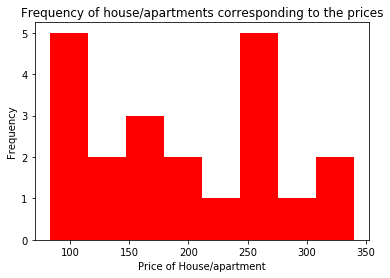

In [69]:
plt.hist(df_manhattan['Price'], 8, color=['red'])
plt.xlabel("Price of House/apartment")
plt.ylabel("Frequency")
plt.title("Frequency of house/apartments corresponding to the prices")
plt.show()

**Preference 9:** Filter out the Airbnb listings that are costlier than 200 dollars

In [70]:
# Filtering on the basis of prices
df_manhattan = df_manhattan[df_manhattan['Price']<=200].reset_index(drop=True)
print('Listings that are available for rent: {}'.format(df_manhattan.shape[0]))
df_manhattan.head()

Listings that are available for rent: 12


,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,3817216,Doorman nice 1bd/ United Nations!!,1475015,Mike,Manhattan,Midtown,40.75021,-73.97137,Entire home/apt,87,30,8,2019-08-28,0.12,52,365
1,5536824,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,Entire home/apt,200,29,9,2018-07-19,0.15,4,365
2,9792323,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,Entire home/apt,83,30,4,2019-09-14,0.10,52,365
3,10291127,Doorman XL one bedroom!5109,16098958,Jeremy & Elsa,Manhattan,Midtown,40.75295,-73.98889,Entire home/apt,160,30,4,2019-03-04,0.10,112,365
4,12887457,=== BRAND NEW = LARGE STUDIO = E 52 St ===,1475015,Mike,Manhattan,Midtown,40.75754,-73.96943,Entire home/apt,115,30,1,2019-12-07,0.30,52,365


#### Let's visualise the available host listings on the map of Manhattan, New York.

In [71]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="man_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan, NY are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan, NY are 40.7896239, -73.9598939.


In [72]:
# Plot Airbnb listings all over New York
map_man = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_manhattan['Latitude'], df_manhattan['Longitude'], df_manhattan['Borough'], df_manhattan['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_man)  
    
map_man

## Foursquare API

**Preference 10:** Now we shall find out the venues nearby (within a radius of 1000 metres from the Airbnb home/apartment) and cluster the similar ones. 
The client can then select the one he prefers from the various clusters.

##### Define Foursquare Credentials and Version

In [99]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


---Define **LIMIT** (limit to the number of venues that Foursquare will return us) to 100.---

In [74]:
LIMIT = 100

---Defining a function **getNearbyVenues** that gets us all the venues---

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results if(v['venue']['categories'][0]['name']!='Hotel')])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name of Airbnb entry', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Calling the above function and store all of these values in a DataFrame.

In [76]:
midtown_venues = getNearbyVenues(names=df_manhattan['Name'],
                                latitudes=df_manhattan['Latitude'],
                                longitudes=df_manhattan['Longitude'])

Doorman nice 1bd/ United Nations!!
2  BEDROOM GREAT  APT ON  LEXINGTON  AVE MUST SEE
Brand New Studio!! UNITED NATIONS!!
Doorman XL one bedroom!5109
=== BRAND NEW = LARGE STUDIO = E 52 St ===
MY HOME / YOUR HOME /BEAUTIFUL HUGE 1BR
LUXE STUDIO SUITE - Midtown East - 22
149 e 39th st 1BR great loc
Bright spacious Studio overlooking Manhattan
Beautiful United Nations Studio/ Best location.
Prime Location 44stDoorman Gym Studio!5217
Studio With Washer Dryer Midtown East


Let's find out the size of the resulting DataFrame.

In [77]:
print(midtown_venues.shape)
midtown_venues.head()

(1148, 7)


,Name of Airbnb entry,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Doorman nice 1bd/ United Nations!!,40.75021,-73.97137,iLoveKickboxing,40.750580,-73.971540,Boxing Gym
1,Doorman nice 1bd/ United Nations!!,40.75021,-73.97137,Tudor City Park South,40.748766,-73.970775,Park
2,Doorman nice 1bd/ United Nations!!,40.75021,-73.97137,Sakagura,40.751305,-73.973314,Sake Bar
3,Doorman nice 1bd/ United Nations!!,40.75021,-73.97137,Sushi Yasuda,40.751097,-73.973495,Sushi Restaurant
4,Doorman nice 1bd/ United Nations!!,40.75021,-73.97137,Tudor City Park North,40.749325,-73.970524,Park


Let's find out the number of venues returned for each Airbnb entry.

In [78]:
midtown_venues.groupby('Name of Airbnb entry').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Name of Airbnb entry,,,,,,
149 e 39th st 1BR great loc,96,96,96,96,96,96
2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,96,96,96,96,96,96
=== BRAND NEW = LARGE STUDIO = E 52 St ===,93,93,93,93,93,93
Beautiful United Nations Studio/ Best location.,95,95,95,95,95,95
Brand New Studio!! UNITED NATIONS!!,96,96,96,96,96,96
Bright spacious Studio overlooking Manhattan,93,93,93,93,93,93
Doorman XL one bedroom!5109,92,92,92,92,92,92
Doorman nice 1bd/ United Nations!!,96,96,96,96,96,96
LUXE STUDIO SUITE - Midtown East - 22,97,97,97,97,97,97


Let's find out how many unique categories can be curated from all the returned venues.

In [79]:
print('Unique categories: {}'.format(len(midtown_venues['Venue Category'].unique())))

Unique categories: 150


### Analyse each Home/Apartment

In [80]:
# one hot encoding
midtown_onehot = pd.get_dummies(midtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add name column back to dataframe
midtown_onehot['Name of Airbnb entry'] = midtown_venues['Name of Airbnb entry'] 

# move neighborhood column to the first column
fixed_columns = [midtown_onehot.columns[-1]] + list(midtown_onehot.columns[:-1])
midtown_onehot = midtown_onehot[fixed_columns]

midtown_onehot.head()

,Name of Airbnb entry,Adult Boutique,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bookstore,Boutique,Boxing Gym,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Café,Camera Store,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Donut Shop,Duty-free Shop,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,Hotel Bar,Indian Restaurant,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Luggage Store,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Non-Profit,Office,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pub,Residential Building (Apartment / Condo),Resort,Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Smoke Shop,Snack Place,South American Restaurant,Spa,Spiritual Center,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Doorman nice 1bd/ United Nations!!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Doorman nice 1bd/ United Nations!!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Doorman nice 1bd/ United Nations!!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Doorman nice 1bd/ United Nations!!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Doorman nice 1bd/ United Nations!!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's check the new DataFrame size.

In [81]:
midtown_onehot.shape

(1148, 151)

Let's group by each Airbnb entry and by taking mean of the frequency of occurrence of each category.

In [82]:
midtown_grouped = midtown_onehot.groupby('Name of Airbnb entry').mean().reset_index()
midtown_grouped.head()

,Name of Airbnb entry,Adult Boutique,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bookstore,Boutique,Boxing Gym,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Café,Camera Store,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Donut Shop,Duty-free Shop,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,Hotel Bar,Indian Restaurant,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Luggage Store,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Non-Profit,Office,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pub,Residential Building (Apartment / Condo),Resort,Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Smoke Shop,Snack Place,South American Restaurant,Spa,Spiritual Center,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,149 e 39th st 1BR great loc,0.000000,0.031250,0.000000,0.000000,0.000000,0.010417,0.000000,0.000000,0.020833,0.031250,0.010417,0.0,0.000000,0.000000,0.000000,0.010417,0.000000,0.020833,0.010417,0.010417,0.010417,0.020833,0.0,0.031250,0.000000,0.0,0.020833,0.000000,0.000000,0.000000,0.000000,0.010417,0.062500,0.010417,0.0,0.010417,0.0,0.000000,0.000000,0.010417,0.0,0.010417,0.000000,0.000000,0.0,0.010417,0.0,0.0,0.010417,0.0,0.010417,0.010417,0.010417,0.0,0.000000,0.010417,0.0,0.010417,0.010417,0.010417,0.020833,0.031250,0.010417,0.000000,0.010417,0.0,0.010417,0.0,0.000000,0.020833,0.000000,0.0,0.010417,0.010417,0.041667,0.010417,0.000000,0.000000,0.020833,0.020833,0.000000,0.010417,0.000000,0.000000,0.000000,0.010417,0.000000,0.0,0.000000,0.000000,0.0,0.010417,0.0,0.0,0.0,0.000000,0.010417,0.0,0.041667,0.0,0.0,0.000000,0.0,0.010417,0.010417,0.000000,0.010417,0.000000,0.010417,0.000000,0.010417,0.010417,0.000000,0.020833,0.000000,0.0,0.000000,0.000000,0.000000,0.010417,0.0,0.0,0.000000,0.000000,0.0,0.010417,0.0,0.031250,0.000000,0.0,0.000000,0.0,0.0,0.010417,0.000000,0.010417,0.010417,0.0,0.010417,0.000000,0.010417,0.010417,0.010417,0.010417,0.000000,0.020833,0.000000,0.000000,0.000000,0.010417
1,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,0.000000,0.052083,0.010417,0.020833,0.000000,0.000000,0.010417,0.010417,0.000000,0.020833,0.031250,0.0,0.010417,0.000000,0.000000,0.010417,0.010417,0.000000,0.000000,0.000000,0.010417,0.010417,0.0,0.041667,0.010417,0.0,0.000000,0.020833,0.000000,0.000000,0.000000,0.020833,0.020833,0.000000,0.0,0.000000,0.0,0.010417,0.000000,0.010417,0.0,0.000000,0.000000,0.020833,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.010417,0.000000,0.0,0.000000,0.000000,0.020833,0.000000,0.010417,0.020833,0.062500,0.000000,0.0,0.000000,0.0,0.010417,0.062500,0.000000,0.0,0.03

Let's check the new size.

In [83]:
midtown_grouped.shape

(12, 151)

Let's print each Airbnb entry along with the top 5 most common venues around it.

In [84]:
num_top_venues = 5

for hood in midtown_grouped['Name of Airbnb entry']:
    print("----"+hood+"----")
    temp = midtown_grouped[midtown_grouped['Name of Airbnb entry'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----149 e 39th st 1BR great loc----
                 venue  freq
0          Coffee Shop  0.06
1  Japanese Restaurant  0.04
2                 Park  0.04
3        Grocery Store  0.03
4  American Restaurant  0.03


----2  BEDROOM GREAT  APT ON  LEXINGTON  AVE MUST SEE----
                  venue  freq
0     Korean Restaurant  0.07
1  Gym / Fitness Center  0.06
2     Indian Restaurant  0.06
3   American Restaurant  0.05
4                  Café  0.04


----=== BRAND NEW = LARGE STUDIO = E 52 St ===----
                venue  freq
0         Coffee Shop  0.05
1       Grocery Store  0.04
2                 Gym  0.04
3                 Spa  0.03
4  Salon / Barbershop  0.03


----Beautiful United Nations Studio/ Best location.----
                 venue  freq
0          Coffee Shop  0.07
1  Japanese Restaurant  0.04
2                 Park  0.03
3  American Restaurant  0.03
4                 Café  0.03


----Brand New Studio!! UNITED NATIONS!!----
                 venue  freq
0          Coffee Shop

Let's shift this data into a pandas DataFrame.

We will write a function to sort the venues in descending order.

In [85]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We shall now record in a DataFrame and display the **top 10 venues** for each Airbnb entry.

In [86]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to the number of top venues
columns = ['Name of Airbnb entry']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicator[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# Create a new DataFrame
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Name of Airbnb entry'] = midtown_grouped['Name of Airbnb entry']

for ind in np.arange(midtown_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = most_common_venues(midtown_grouped.iloc[ind, 1:], num_top_venues)
    
venues_sorted

,Name of Airbnb entry,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,149 e 39th st 1BR great loc,Coffee Shop,Park,Japanese Restaurant,American Restaurant,Grocery Store,Bakery,Sushi Restaurant,Café,Burger Joint,Greek Restaurant
1,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,Korean Restaurant,Gym / Fitness Center,Indian Restaurant,American Restaurant,Café,Japanese Restaurant,New American Restaurant,Bar,Italian Restaurant,Yoga Studio
2,=== BRAND NEW = LARGE STUDIO = E 52 St ===,Coffee Shop,Gym,Grocery Store,American Restaurant,Salon / Barbershop,Italian Restaurant,Gym / Fitness Center,Bakery,Spa,Restaurant
3,Beautiful United Nations Studio/ Best location.,Coffee Shop,Japanese Restaurant,American Restaurant,Grocery Store,Park,Sushi Restaurant,Sandwich Place,Indian Restaurant,Café,Boxing Gym
4,Brand New Studio!! UNITED NATIONS!!,Coffee Shop,Japanese Restaurant,American Restaurant,Grocery Store,Park,Sushi Restaurant,Sandwich Place,Indian Restaurant,Café,Thai Restaurant
5,Bright spacious Studio overlooking Manhattan,Theater,Korean Restaurant,Burger Joint,American Restaurant,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Bookstore,Steakhouse,Coffee Shop
6,Doorman XL one bedroom!5109,Theater,Korean Restaurant,Burger Joint,Dance Studio,Italian Restaurant,Martial Arts Dojo,Mediterranean Restaurant,Grocery Store,Chinese Restaurant,Music Venue
7,Doorman nice 1bd/ United Nations!!,Coffee Shop,Japanese Restaurant,American Restaurant,Café,Sushi Restaurant,Sandwich Place,Grocery Store,Bakery,Boxing Gym,Karaoke Bar
8,LUXE STUDIO SUITE - Midtown East - 22,Gym / Fitness Center,Coffee Shop,Italian Restaurant,American Restaurant,Bakery,Wine Bar,Salon / Barbershop,Gym,Indian Restaurant,Seafood Restaurant
9,MY HOME / YOUR HOME /BEAUTIFUL HUGE 1BR,Italian Restaurant,Coffee Shop,Gym / Fitness Center,American Restaurant,Bakery,Park,Salon / Barbershop,Wine Bar,Indian Restaurant,Restaurant


Let's make a copy on the DataFrame 'df_manhattan' so we can join this dataframe with the dataframe of most common venues available around the homes/apartments.

In [87]:
df_midtown = df_manhattan.copy()

df_midtown.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,3817216,Doorman nice 1bd/ United Nations!!,1475015,Mike,Manhattan,Midtown,40.75021,-73.97137,Entire home/apt,87,30,8,2019-08-28,0.12,52,365
1,5536824,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,Entire home/apt,200,29,9,2018-07-19,0.15,4,365
2,9792323,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,Entire home/apt,83,30,4,2019-09-14,0.10,52,365
3,10291127,Doorman XL one bedroom!5109,16098958,Jeremy & Elsa,Manhattan,Midtown,40.75295,-73.98889,Entire home/apt,160,30,4,2019-03-04,0.10,112,365
4,12887457,=== BRAND NEW = LARGE STUDIO = E 52 St ===,1475015,Mike,Manhattan,Midtown,40.75754,-73.96943,Entire home/apt,115,30,1,2019-12-07,0.30,52,365


In [88]:
df_midtown = df_midtown.sort_values("Name", axis = 0, ascending = True).reset_index(drop=True)
df_midtown.head()

,ID,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,No. of Reviews,Last Review,Reviews per Month,Calculated host listings count,Availability
0,16378007,149 e 39th st 1BR great loc,53179388,Raymond,Manhattan,Midtown,40.75006,-73.97007,Entire home/apt,190,30,4,2019-11-02,0.12,7,365
1,5536824,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,Entire home/apt,200,29,9,2018-07-19,0.15,4,365
2,12887457,=== BRAND NEW = LARGE STUDIO = E 52 St ===,1475015,Mike,Manhattan,Midtown,40.75754,-73.96943,Entire home/apt,115,30,1,2019-12-07,0.30,52,365
3,25371837,Beautiful United Nations Studio/ Best location.,1475015,Mike,Manhattan,Midtown,40.75215,-73.97152,Entire home/apt,83,30,1,2020-01-05,0.43,52,365
4,9792323,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,Entire home/apt,83,30,4,2019-09-14,0.10,52,365


We will now drop the columns that have already been filtered and don't need to be shown to the customer.

In [89]:
df_midtown = df_midtown.drop(['ID', 'Room Type', 'Reviews per Month', 'Calculated host listings count', 'Availability'], axis=1)
df_midtown.head()

,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Price,Minimum Nights,No. of Reviews,Last Review
0,149 e 39th st 1BR great loc,53179388,Raymond,Manhattan,Midtown,40.75006,-73.97007,190,30,4,2019-11-02
1,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,200,29,9,2018-07-19
2,=== BRAND NEW = LARGE STUDIO = E 52 St ===,1475015,Mike,Manhattan,Midtown,40.75754,-73.96943,115,30,1,2019-12-07
3,Beautiful United Nations Studio/ Best location.,1475015,Mike,Manhattan,Midtown,40.75215,-73.97152,83,30,1,2020-01-05
4,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,83,30,4,2019-09-14


In [90]:
result = pd.concat([df_midtown, venues_sorted], axis=1, sort=False)
result = result.drop(['Name of Airbnb entry'], axis=1)
print(result.shape)
result.head()

(12, 21)


,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Price,Minimum Nights,No. of Reviews,Last Review,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,149 e 39th st 1BR great loc,53179388,Raymond,Manhattan,Midtown,40.75006,-73.97007,190,30,4,2019-11-02,Coffee Shop,Park,Japanese Restaurant,American Restaurant,Grocery Store,Bakery,Sushi Restaurant,Café,Burger Joint,Greek Restaurant
1,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,200,29,9,2018-07-19,Korean Restaurant,Gym / Fitness Center,Indian Restaurant,American Restaurant,Café,Japanese Restaurant,New American Restaurant,Bar,Italian Restaurant,Yoga Studio
2,=== BRAND NEW = LARGE STUDIO = E 52 St ===,1475015,Mike,Manhattan,Midtown,40.75754,-73.96943,115,30,1,2019-12-07,Coffee Shop,Gym,Grocery Store,American Restaurant,Salon / Barbershop,Italian Restaurant,Gym / Fitness Center,Bakery,Spa,Restaurant
3,Beautiful United Nations Studio/ Best location.,1475015,Mike,Manhattan,Midtown,40.75215,-73.97152,83,30,1,2020-01-05,Coffee Shop,Japanese Restaurant,American Restaurant,Grocery Store,Park,Sushi Restaurant,Sandwich Place,Indian Restaurant,Café,Boxing Gym
4,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,83,30,4,2019-09-14,Coffee Shop,Japanese Restaurant,American Restaurant,Grocery Store,Park,Sushi Restaurant,Sandwich Place,Indian Restaurant,Café,Thai Restaurant


### Clustering of Airbnb entries


**K means clustering** is used for clustering. **Silhouette Coefficient** is used to find out the most optimal number of cluster.

Silhouette Coefficient = **(x-y)/ max(x,y)**

where, y is the mean intra cluster distance: mean distance to the other instances in the same cluster. x depicts mean nearest cluster distance i.e. mean distance to the instances of the next closest cluster.


The coefficient varies between -1 and 1. A value close to 1 implies that the instance is close to its cluster is a part of the right cluster. Whereas, a value close to -1 means that the value is assigned to the wrong cluster.

In [91]:
midtown_grouped_clustering = midtown_grouped.drop('Name of Airbnb entry', 1)

for n_cluster in range(2, 12):
    kmeans = KMeans(n_clusters=n_cluster).fit(midtown_grouped_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(midtown_grouped_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.42686811699065125
For n_clusters=3, The Silhouette Coefficient is 0.44622892055271257
For n_clusters=4, The Silhouette Coefficient is 0.483526612083085
For n_clusters=5, The Silhouette Coefficient is 0.43687794174626454
For n_clusters=6, The Silhouette Coefficient is 0.3808981726763572
For n_clusters=7, The Silhouette Coefficient is 0.3246550780141417
For n_clusters=8, The Silhouette Coefficient is 0.2224120436284834
For n_clusters=9, The Silhouette Coefficient is 0.20482949434677988
For n_clusters=10, The Silhouette Coefficient is 0.18879639215722865
For n_clusters=11, The Silhouette Coefficient is 0.10833993247596675


As we can see from the above results, we get the optimum clustering results at **4 clusters**. So we will run k-means clustering to cluster the Airbnb homes/apartments into 4 clusters.

In [92]:
# set number of clusters
n_clusters = 4

# Run k-means clustering
kmeans = KMeans(n_clusters=n_clusters).fit(midtown_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 3, 2, 0, 0, 1, 1, 0, 2, 2, 0, 2], dtype=int32)

Let's add cluster labels to the final DataFrame created above as **result**.

In [93]:
# Add clustering labels
result.insert(11, 'Cluster Labels', kmeans.labels_)
result.head()

,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Price,Minimum Nights,No. of Reviews,Last Review,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,149 e 39th st 1BR great loc,53179388,Raymond,Manhattan,Midtown,40.75006,-73.97007,190,30,4,2019-11-02,0,Coffee Shop,Park,Japanese Restaurant,American Restaurant,Grocery Store,Bakery,Sushi Restaurant,Café,Burger Joint,Greek Restaurant
1,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,200,29,9,2018-07-19,3,Korean Restaurant,Gym / Fitness Center,Indian Restaurant,American Restaurant,Café,Japanese Restaurant,New American Restaurant,Bar,Italian Restaurant,Yoga Studio
2,=== BRAND NEW = LARGE STUDIO = E 52 St ===,1475015,Mike,Manhattan,Midtown,40.75754,-73.96943,115,30,1,2019-12-07,2,Coffee Shop,Gym,Grocery Store,American Restaurant,Salon / Barbershop,Italian Restaurant,Gym / Fitness Center,Bakery,Spa,Restaurant
3,Beautiful United Nations Studio/ Best location.,1475015,Mike,Manhattan,Midtown,40.75215,-73.97152,83,30,1,2020-01-05,0,Coffee Shop,Japanese Restaurant,American Restaurant,Grocery Store,Park,Sushi Restaurant,Sandwich Place,Indian Restaurant,Café,Boxing Gym
4,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,83,30,4,2019-09-14,0,Coffee Shop,Japanese Restaurant,American Restaurant,Grocery Store,Park,Sushi Restaurant,Sandwich Place,Indian Restaurant,Café,Thai Restaurant


**VISUALISATION:** Let's visualise the clusters on the map of New York.

In [94]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result['Latitude'], result['Longitude'],result['Neighbourhood'], result['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### Examining Clusters

We can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1

In [95]:
cluster1 = result[result['Cluster Labels']==0]
cluster1

,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Price,Minimum Nights,No. of Reviews,Last Review,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,149 e 39th st 1BR great loc,53179388,Raymond,Manhattan,Midtown,40.75006,-73.97007,190,30,4,2019-11-02,0,Coffee Shop,Park,Japanese Restaurant,American Restaurant,Grocery Store,Bakery,Sushi Restaurant,Café,Burger Joint,Greek Restaurant
3,Beautiful United Nations Studio/ Best location.,1475015,Mike,Manhattan,Midtown,40.75215,-73.97152,83,30,1,2020-01-05,0,Coffee Shop,Japanese Restaurant,American Restaurant,Grocery Store,Park,Sushi Restaurant,Sandwich Place,Indian Restaurant,Café,Boxing Gym
4,Brand New Studio!! UNITED NATIONS!!,1475015,Mike,Manhattan,Midtown,40.75161,-73.97109,83,30,4,2019-09-14,0,Coffee Shop,Japanese Restaurant,American Restaurant,Grocery Store,Park,Sushi Restaurant,Sandwich Place,Indian Restaurant,Café,Thai Restaurant
7,Doorman nice 1bd/ United Nations!!,1475015,Mike,Manhattan,Midtown,40.75021,-73.97137,87,30,8,2019-08-28,0,Coffee Shop,Japanese Restaurant,American Restaurant,Café,Sushi Restaurant,Sandwich Place,Grocery Store,Bakery,Boxing Gym,Karaoke Bar
10,Prime Location 44stDoorman Gym Studio!5217,16098958,Jeremy & Elsa,Manhattan,Midtown,40.75032,-73.97143,175,30,1,2019-07-31,0,Coffee Shop,Japanese Restaurant,American Restaurant,Bakery,Sandwich Place,Grocery Store,Sushi Restaurant,Café,Karaoke Bar,Juice Bar


#### Cluster 2

In [96]:
cluster2 = result[result['Cluster Labels']==1]
cluster2

,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Price,Minimum Nights,No. of Reviews,Last Review,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Bright spacious Studio overlooking Manhattan,168121995,Mayra,Manhattan,Midtown,40.75241,-73.98558,135,456,3,2019-01-31,1,Theater,Korean Restaurant,Burger Joint,American Restaurant,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Bookstore,Steakhouse,Coffee Shop
6,Doorman XL one bedroom!5109,16098958,Jeremy & Elsa,Manhattan,Midtown,40.75295,-73.98889,160,30,4,2019-03-04,1,Theater,Korean Restaurant,Burger Joint,Dance Studio,Italian Restaurant,Martial Arts Dojo,Mediterranean Restaurant,Grocery Store,Chinese Restaurant,Music Venue


#### Cluster 3

In [97]:
cluster3 = result[result['Cluster Labels']==2]
cluster3

,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Price,Minimum Nights,No. of Reviews,Last Review,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,=== BRAND NEW = LARGE STUDIO = E 52 St ===,1475015,Mike,Manhattan,Midtown,40.75754,-73.96943,115,30,1,2019-12-07,2,Coffee Shop,Gym,Grocery Store,American Restaurant,Salon / Barbershop,Italian Restaurant,Gym / Fitness Center,Bakery,Spa,Restaurant
8,LUXE STUDIO SUITE - Midtown East - 22,80479138,Gordon,Manhattan,Midtown,40.75965,-73.96631,140,30,14,2020-02-02,2,Gym / Fitness Center,Coffee Shop,Italian Restaurant,American Restaurant,Bakery,Wine Bar,Salon / Barbershop,Gym,Indian Restaurant,Seafood Restaurant
9,MY HOME / YOUR HOME /BEAUTIFUL HUGE 1BR,1475015,Mike,Manhattan,Midtown,40.75721,-73.96496,95,30,5,2019-05-30,2,Italian Restaurant,Coffee Shop,Gym / Fitness Center,American Restaurant,Bakery,Park,Salon / Barbershop,Wine Bar,Indian Restaurant,Restaurant
11,Studio With Washer Dryer Midtown East,61396454,Ash,Manhattan,Midtown,40.75596,-73.96482,165,30,2,2020-02-28,2,Park,American Restaurant,Coffee Shop,Bakery,Italian Restaurant,Gym / Fitness Center,Grocery Store,Wine Bar,Café,French Restaurant


#### Cluster 4

In [98]:
cluster4 = result[result['Cluster Labels']==3]
cluster4

,Name,Host ID,Host Name,Borough,Neighbourhood,Latitude,Longitude,Price,Minimum Nights,No. of Reviews,Last Review,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,2 BEDROOM GREAT APT ON LEXINGTON AVE MUST SEE,24715671,Julia,Manhattan,Midtown,40.74294,-73.98499,200,29,9,2018-07-19,3,Korean Restaurant,Gym / Fitness Center,Indian Restaurant,American Restaurant,Café,Japanese Restaurant,New American Restaurant,Bar,Italian Restaurant,Yoga Studio


### Clustering results

**Cluster 1:** The most common venues available around the host listings include Coffee Shops, Japanese Restaurants, and American Restaurants.

**Cluster 2:** The most common venues available around the host listings include Theaters, Korean Restaurants, and Burger Joints.

**Cluster 3:** The most common venues available around the host listings include Coffee Shops, Gym/Fitness Centres, and American Restaurants.

**Cluster 4:** The most common venues available around the host listings include Korean Restaurants, Gym/Fitness Centres, and Indian Restaurants.
